In [91]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [169]:
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import flax.linen as nn

from sklearn.datasets import make_moons
from rebayes_mini import callbacks
from functools import partial
from rebayes_mini.methods import recursive_vi_gauss as rvga

In [12]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["font.size"] = 15
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rc("text", usetex=True)

sns.set_palette("colorblind")
palette = sns.color_palette()

In [13]:
palette = sns.color_palette()

In [20]:
n_samples = 500
X, y = make_moons(n_samples, noise=0.15, random_state=314)

angle = jnp.pi * -0.3
R = jnp.array([
    [jnp.cos(angle), -jnp.sin(angle)],
    [jnp.sin(angle), jnp.cos(angle)]
])
X = jnp.einsum("mn,sn->sm", R, X)

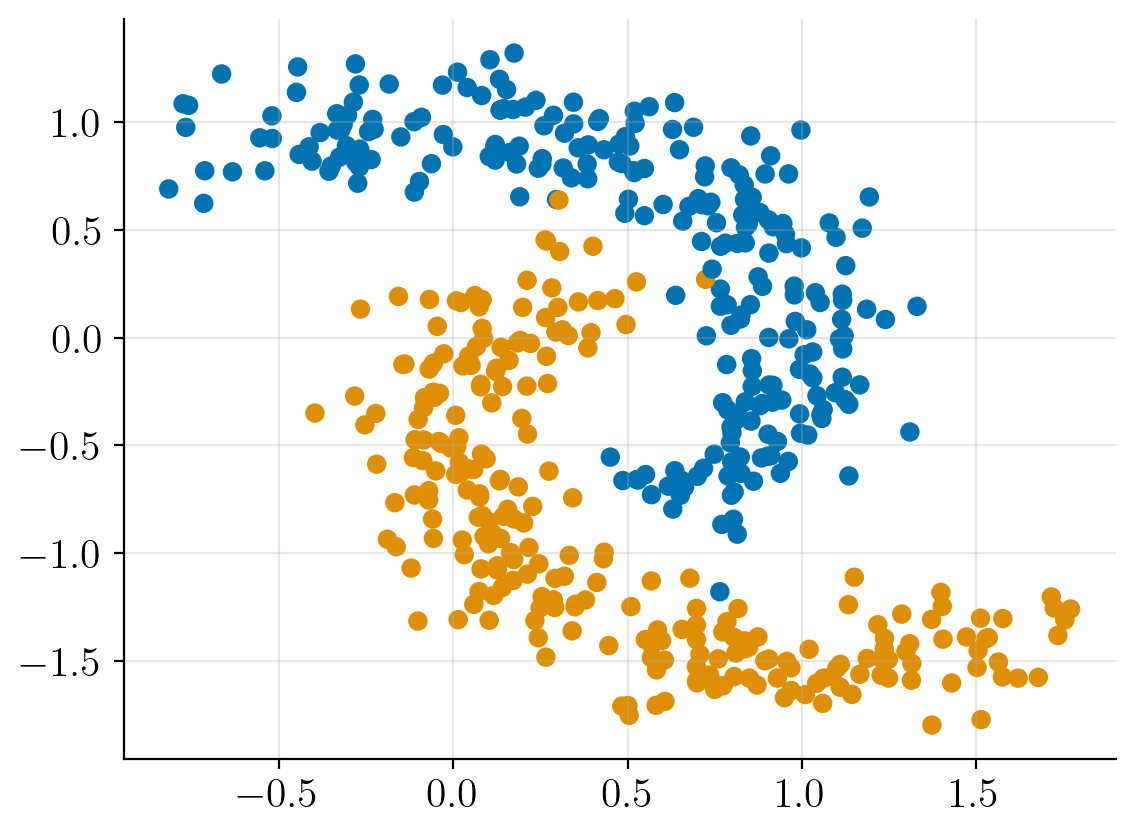

In [21]:
colors = [palette[v] for v in y]
plt.scatter(*X.T, c=colors)
plt.grid(alpha=0.3)

In [181]:
class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(5)(x)
        x = nn.relu(x)
        x = nn.Dense(5)(x)
        x = nn.relu(x)
        # x = nn.Dense(10)(x)
        # x = nn.relu(x)
        x = nn.Dense(1)(x)
        # x = nn.sigmoid(x)
        return x

In [182]:
key = jax.random.PRNGKey(314)
key_init, key_run = jax.random.split(key)

In [183]:
mlp = MLP()
params_init = mlp.init(key_init, X)

In [184]:
rvga_filter = rvga.BernoulliRVGA(mlp.apply, n_inner=2, n_samples=100)
bel_init = rvga_filter.init_bel(params_init)

In [185]:
bel_final, bel_hist = rvga_filter.scan(key_run, bel_init, y[:, None], X, callbacks.get_updated_bel)

In [186]:
preds = rvga_filter.mean(rvga_filter.link_fn(bel_final.mean, X).squeeze()).round()
(preds == y).mean()

Array(0.952, dtype=float32)

In [198]:
vmin, vmax = -1.5, 1.5
x1 = jnp.linspace(-1.5, 1.5, 20)
x2 = jnp.linspace(-1.5, 1.5, 25)
Z = jnp.mgrid[vmin:vmax:20j,vmin:vmax:25j]
# Z = jnp.einsum("nm,mij->nij", R, Z)

In [199]:
Z.shape

(2, 20, 25)

In [200]:
X.shape

(500, 2)

In [201]:
@partial(jax.vmap, in_axes=(None, 2))
@partial(jax.vmap, in_axes=(None, 1))
def vpred(params, X):
    return rvga_filter.mean(rvga_filter.link_fn(bel_final.mean, X).squeeze())

In [202]:
S = vpred(bel_final.mean, Z)

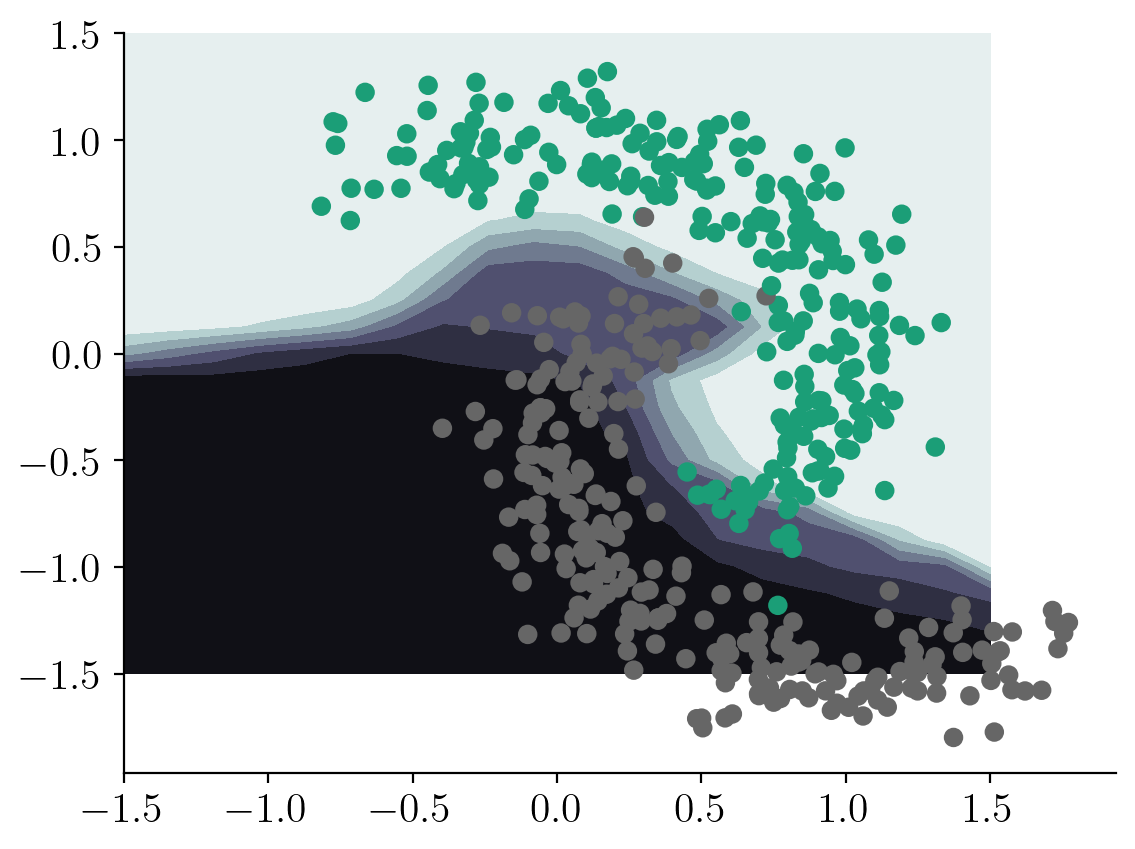

In [205]:
t = -1
plt.contourf(x1, x2, S, cmap="bone_r")
plt.scatter(*X[:t].T, c=y[:t], cmap="Dark2")

In [ ]:
rvga_filter.link_fn()